# Part 3 of notebook

## 7. Test methods on pre-trained net

The CNN studied in parts 1 and 2 is extremely shallow compared to high-performance neural net architectures. The [resnet34 model](https://www.kaggle.com/pytorch/resnet34) is a popular contest-winning CNN that has been pre-trained on a diverse image set. A much higher level of accuracy and prediction confidence is obtained, although it is unclear whether the confidence thresholding method will more or less effective as a result.

The same training data set used in section 3 (without Dwayne Johnson) is used to update the weights for resnet34.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms, utils, datasets, models
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from helper_functions_clean import *

In [2]:
data_dir = 'data/rps/'
class_names, dataloaders = get_data_loaders_init(data_dir)
trainloader = dataloaders['train']
validloader = dataloaders['valid']

In [3]:
net_resnet34 = models.resnet34(pretrained=True)
net_resnet34.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_resnet34.parameters(), lr=0.001, momentum=0.9)
training_stats_resnet34 = []

for epoch in range(30):
    
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        optimizer.zero_grad()
        outputs = net_resnet34(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0]
    
    valid_loss = 0
    for j, data in enumerate(validloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        outputs = net_resnet34(inputs)
        loss = criterion(outputs, labels)
        valid_loss += loss.data[0]
        
#     ground_truth, probability_list_base_classes, prediction = prediction_list(validloader, net_resnet34)
#     valid_loss = criterion(prediction, ground_truth)
        
    training_stats_resnet34.append(get_net_accuracy_stats(dataloaders, net_resnet34, epoch))
    print('epoch: %d, train loss: %.3f, valid loss: %.3f' % (epoch + 1, running_loss/(trainloader.batch_size*i), valid_loss/(validloader.batch_size*j)))

print('Finished Training')

epoch: 1, train loss: 0.230, valid loss: 0.162
epoch: 2, train loss: 0.133, valid loss: 0.094
epoch: 3, train loss: 0.112, valid loss: 0.109
epoch: 4, train loss: 0.096, valid loss: 0.050
epoch: 5, train loss: 0.086, valid loss: 0.057
epoch: 6, train loss: 0.083, valid loss: 0.066
epoch: 7, train loss: 0.077, valid loss: 0.076
epoch: 8, train loss: 0.063, valid loss: 0.073
epoch: 9, train loss: 0.055, valid loss: 0.039
epoch: 10, train loss: 0.061, valid loss: 0.048
epoch: 11, train loss: 0.056, valid loss: 0.049
epoch: 12, train loss: 0.063, valid loss: 0.039
epoch: 13, train loss: 0.050, valid loss: 0.044
epoch: 14, train loss: 0.045, valid loss: 0.046
epoch: 15, train loss: 0.046, valid loss: 0.031
epoch: 16, train loss: 0.051, valid loss: 0.038
epoch: 17, train loss: 0.041, valid loss: 0.035
epoch: 18, train loss: 0.043, valid loss: 0.022
epoch: 19, train loss: 0.043, valid loss: 0.024
epoch: 20, train loss: 0.041, valid loss: 0.030
epoch: 21, train loss: 0.036, valid loss: 0.033
e

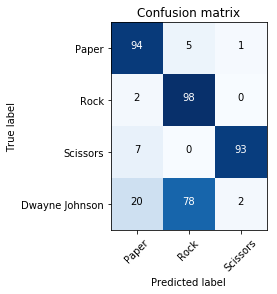

In [5]:
rockloader = dataloaders['dwayne_johnson']
ground_truth, probability_list_base_classes, prediction = prediction_list_resnet34(validloader, net_resnet34)
probability_list_dj, prediction_dj = predict_proba_for_hidden_class_resnet34(rockloader, net_resnet34)
cnf_matrix = confusion_matrix(ground_truth, prediction)
plot_confusion_matrix_hidden_class(cnf_matrix, class_names, prediction_dj, 'Dwayne Johnson', title='Confusion matrix')

As expected, a much higher level of classification accuracy is achieved using resnet34. Most images of Dwayne Johnson are categorized as rocks at a similar rate to the smaller net.

This increase in base class accuracy comes at the cost of interpretability. The first layer alone outputs 64 channels, visualized below.

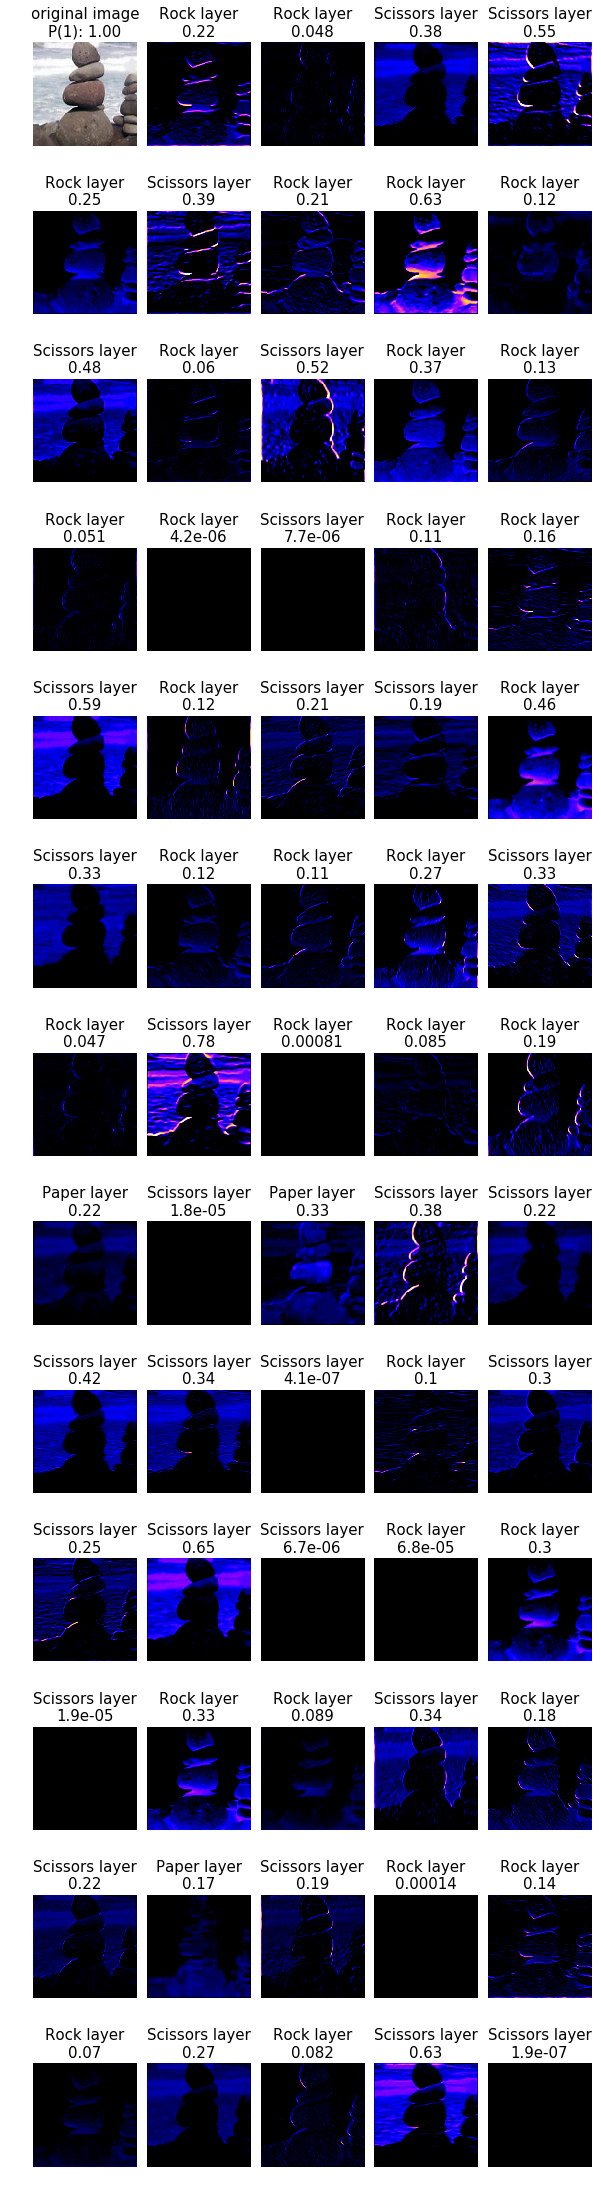

In [6]:
modulelist_resnet = list(net_resnet34.modules())[1:]
valid_path = data_dir + 'valid/' + '{}/'
layer_activation_strength, strongest_activator = layers_by_classification(valid_path, class_names, net_resnet34, 1)
modulelist_resnet = list(net_resnet34.modules())[1:]
im_path = 'data/rps/valid/Rock/pic_043.jpg'
plot_first_layer_with_strongest_activator_resnet(im_path, modulelist_resnet[0], strongest_activator, net_resnet34, class_names)

Again, the confidence associated predictions varies greatly between base classes and Dwayne Johnson. The vast majority of base classes have a probability of membership above 0.9. With the more advanced architecture, Dwayne Johnson's probabilities tend to be even lower.

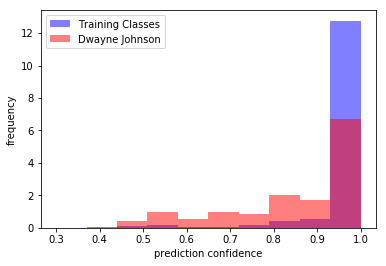

In [7]:
plt.hist(probability_list_base_classes, density=True, fc = [0,0,1,0.5], range = (0.3,1))
plt.hist(probability_list_dj, density = True, fc = [1, 0, 0, 0.5], range = (0.3,1))
plt.legend(['Training Classes', 'Dwayne Johnson']); plt.ylabel('frequency'); plt.xlabel('prediction confidence'); plt.show()

Applying a confidence threshold re-introduces the tradeoff between recall and false-positive rates. Despite the increased net complexity, increases in confidence thresholding cannot reasonably reduce misclassifications to a negligible level.

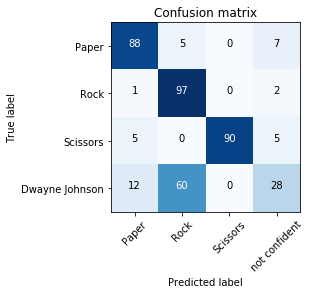

In [8]:
confidence_threshold = 0.8
adjusted_pred_dj = [pred if proba > confidence_threshold else len(class_names) for proba, pred in zip(probability_list_dj, prediction_dj)]
adjusted_pred_base_classes = [pred if proba > confidence_threshold else len(class_names) for proba, pred in zip(probability_list_base_classes, prediction)]
cnf_matrix_adjusted = confusion_matrix(ground_truth, adjusted_pred_base_classes)
hidden_class_confusion = [adjusted_pred_dj.count(i) for i in range(4)]
cnf_matrix_adjusted[-1:] = hidden_class_confusion

plot_confusion_matrix_extra_label(cnf_matrix_adjusted, class_names, 'not confident', 'Dwayne Johnson')

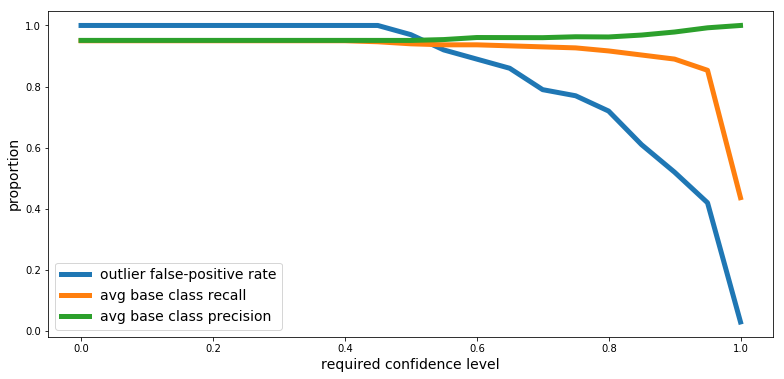

In [9]:
accuracy_vs_confidence_plot(ground_truth, probability_list_base_classes, prediction, probability_list_dj, prediction_dj, class_names)

## 8. Conclusions and future work

Inclusion of outlier example images in the training set is the most effective way to prevent embarrassing misclassifications. This method is most applicable when the classifier is deployed in a low-stakes environment and can be updated periodically (ex: automatic tagging of friends on Facebook).

Confidence thresholding is less effective, but is an a priori way to prevent over-generalization of the CNN classifier. An example implementation could be that when self-driving cars encounter classification uncertainty, they automatically slow down or stop altogether.

Future work could investigate whether these methods remain effective when there are many more classes present (hundreds), or when the classes are much harder to distinguish (ex: rocks vs sandstones). My initial hypothesis is that, while seemingly difficult to humans, complex CNNs will continue to do an excellent job of distinguishing nuanced classes, and that the methods explored above will apply with equal force. For example Kaggle's famous [dog breed identification challenge](https://www.kaggle.com/c/dog-breed-identification) is routinely solved with [high accuracy](https://towardsdatascience.com/dog-breed-classification-hands-on-approach-b5e4f88c333e), despite containing 120 different classes of dog breed. 